- **GPU Acceleration**

In [1]:
# import cuml.accel
# cuml.accel.install()

# Imports

In [2]:
import pathlib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef)
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.ensemble import BalancedBaggingClassifier
from dd_hybrid_sampler import DDHybridSampler
from cost_sensitive import OverBoostClassifier

from pathlib import Path

# Dataset Listing and Loading

In [3]:
def read_data(path: Path):
    if path.suffix == ".csv":
        return pd.read_csv(path)
    else:                       # Excel
        return pd.read_excel(path)

- Dataset path:

In [4]:
DATA_DIR   = Path("Imbalanced_datasets") / "binary"         # CSV files
CSV_FILES  = sorted(DATA_DIR.glob("*.csv"))
assert CSV_FILES, "No CSV found"


- Result save path

In [5]:
OUT_DIR = pathlib.Path("output") / "binary"  
OUT_DIR.mkdir(exist_ok=True, parents=True)

- All avalable datasets:

In [6]:
for i, f in enumerate(CSV_FILES):
    print(i ,f.name)

0 BigML_Dataset.csv
1 MBA.csv
2 Satimage.csv
3 abalone-17_vs_7-8-9-10.csv
4 abalone-19_vs_10-11-12-13.csv
5 abalone-20_vs_8-9-10.csv
6 abalone.csv
7 abalone19.csv
8 abalone_20.csv
9 brain_stroke.csv
10 breast_cancer_wisconsin.csv
11 car_good.csv
12 cervical.csv
13 cirrhosis.csv
14 cleveland-0_vs_4.csv
15 compile_level_01.csv
16 df_train1.csv
17 diabetes.csv
18 ecoli-0-1-4-7_vs_2-3-5-6.csv
19 ecoli-0-1-4-7_vs_5-6.csv
20 ecoli-0-2-3-4_vs_5.csv
21 ecoli-0-2-6-7_vs_3-5.csv
22 ecoli-0-3-4-6_vs_5.csv
23 ecoli-0-3-4-7_vs_5-6.csv
24 ecoli-0-3-4_vs_5.csv
25 ecoli-0-4-6_vs_5.csv
26 ecoli-0-6-7_vs_3-5.csv
27 ecoli-0-6-7_vs_5.csv
28 ecoli-0_vs_1.csv
29 ecoli2.csv
30 ecoli3.csv
31 ecoli4.csv
32 ecoli_013vs26.csv
33 flaref.csv
34 glass-0-1-4-6_vs_2.csv
35 glass-0-1-5_vs_2.csv
36 glass-0-1-6_vs_2.csv
37 glass-0-1-6_vs_5.csv
38 glass-0-4_vs_5.csv
39 glass-0-6_vs_5.csv
40 glass0.csv
41 glass1.csv
42 glass2.csv
43 glass4.csv
44 glass6.csv
45 hcv_binary_mice.csv
46 hcv_data_binary.csv
47 hf.csv
48 ionosp

# Machine Learning Pipeline

## ML Model

In [7]:

CV         = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
CLASSIFIER = RandomForestClassifier(n_estimators=300,
                                    n_jobs=-1,
                                    random_state=42)


## Sampling Algorithms

In [8]:

SAMPLERS   = {
    "None"          : None,
    "SMOTE"         : SMOTE(random_state=42),
    "OverSample"    : RandomOverSampler(random_state=42),
    "DownSample"    : RandomUnderSampler(random_state=42),
    "SMOTE_Bagging" : BalancedBaggingClassifier(random_state=84, sampler = SMOTE(random_state=100, k_neighbors=2)),
    "CNN"           : CondensedNearestNeighbour(random_state=10, n_jobs=-1),
    "NC"            : NeighbourhoodCleaningRule(),
    "ICost"         : OverBoostClassifier(random_state=84),
    "DD_Hybrid"     : DDHybridSampler(target_ir=1.5, k=5, random_state=42)
}

SAMPLE_MODEL = ["ICost", "SMOTE_Bagging"]

## Model Metrics

In [9]:

METRICS    = ["accuracy", "macro_precision", "macro_recall", "macro_f1",
              "weighted_precision", "weighted_recall", "weighted_f1", "mcc"]

## Model Pipeline

In [10]:
def build_pipeline(sampler, classifier=CLASSIFIER) -> ImbPipeline:
    steps = [
        ("impute", SimpleImputer(strategy="median")),
        ("scale" , StandardScaler()),          # optional but cheap
    ]
    if sampler is not None:
        steps.append(("sample", sampler))
    steps.append(("clf", classifier))
    return ImbPipeline(steps)

## Scoring function

In [33]:
def score_fold(y_true, y_pred, NAN=False) -> dict:
    if NAN:
        return {
            "accuracy"          : np.nan,
            "macro_precision"   : np.nan,
            "macro_recall"      : np.nan,
            "macro_f1"          : np.nan,
            "weighted_precision": np.nan,
            "weighted_recall"   : np.nan,
            "weighted_f1"       : np.nan,
            "mcc"               : np.nan,
        }
    return {
        "accuracy"          : accuracy_score(y_true, y_pred),
        "macro_precision"   : precision_score(y_true, y_pred,
                                              average="macro", zero_division=0),
        "macro_recall"      : recall_score(y_true, y_pred,
                                           average="macro", zero_division=0),
        "macro_f1"          : f1_score(y_true, y_pred,
                                       average="macro", zero_division=0),
        "weighted_precision": precision_score(y_true, y_pred,
                                              average="weighted", zero_division=0),
        "weighted_recall"   : recall_score(y_true, y_pred,
                                           average="weighted", zero_division=0),
        "weighted_f1"       : f1_score(y_true, y_pred,
                                       average="weighted", zero_division=0),
        "mcc"               : matthews_corrcoef(y_true, y_pred),
    }

# Master loop – run pipelines

For all Datasets
- Loading Dataset
- Label Encoding
- Loop for all Sampling Algorithms
- Build Pipeline
- Train-Test model with StratifiedkFold
- Save the scores

In [12]:
def imbalance_ratio(y):
    """
    y : 1-D numpy array of class labels
    returns IR (float) = majority_count / minority_count
    """
    counts = np.bincount(y)          # works for integer-encoded labels
    return counts.max() / counts.min()

In [13]:
# # scores = {m: {s: {} for s in SAMPLERS} for m in METRICS}   # metric -> sampler -> dataset -> score
# scores = {m: {**{name: {} for name in SAMPLERS},   # real samplers
#             'IR': {}}                            # IR slot
#             for m in METRICS}

# total_dataset = len(CSV_FILES)
# for di, dataset_path in enumerate(CSV_FILES):
#     ds_name = dataset_path.stem
#     print(f"\n{di}/{total_dataset} - Processing {ds_name}" , end="\t\t")
    
#     # load + basic cleaning
#     df = read_data(dataset_path)
#     df = df.dropna(subset=[df.columns[-1]])
#     if df.shape[0] < 20:
#         print("Too few samples (<20). Skipping...")
#         continue
#     print("Target Size = ", df.shape, "\t", "No. of classes = ", df.iloc[:, -1].nunique())

#     X = df.iloc[:, :-1].copy()
#     y = LabelEncoder().fit_transform(df.iloc[:, -1])

    
#     cat_cols = X.select_dtypes(exclude=np.number).columns
#     if len(cat_cols):
#         X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    

#     for samp_name, sampler in SAMPLERS.items():
#         print("\t- Performing Cross-Validation on : ", samp_name)
#         if samp_name in SAMPLE_MODEL:
#             pipe = build_pipeline(None, classifier=sampler)
#         else:
#             pipe = build_pipeline(sampler)
#         fold_scores = {m: [] for m in METRICS}
        
#         for train_idx, val_idx in CV.split(X, y):
#             X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#             y_train, y_val = y[train_idx], y[val_idx]
            
#             pipe.fit(X_train, y_train)          # ALL steps fitted only on train
#             y_pred = pipe.predict(X_val)
            
#             for k, v in score_fold(y_val, y_pred).items():
#                 fold_scores[k].append(v)
        
#         # mean across folds
#         for m in METRICS:
#             scores[m]["IR"][ds_name] = imbalance_ratio(y)
#             scores[m][samp_name][ds_name] = np.mean(fold_scores[m])

In [14]:
pipe = build_pipeline("SMOTE")
clf = pipe[-1]
print(hasattr(pipe[-1], 'n_neighbors'))
dir(clf)

False


['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_compute_oob_predictions',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_estimators_indices',
 '_get_metadata_request',
 '_get_oob_predictions',
 '_get_param_names',
 '_get_params_html',
 '_html_repr',
 '_make_estimator',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_o

In [37]:
CACHE_FILE = pathlib.Path("cv_scores_cache.json")   # <── per-dataset results
CACHE_FILE.parent.mkdir(exist_ok=True)

# load previous runs (if any)
if CACHE_FILE.exists():
    with open(CACHE_FILE) as f:
        scores = json.load(f)
else:
    scores = {m: {**{name: {} for name in SAMPLERS}} for m in METRICS}
    scores["IR"] = {}

total_dataset = len(CSV_FILES)
for di, dataset_path in enumerate(CSV_FILES):
    ds_name = dataset_path.stem
    print(f"\n{di+1}/{total_dataset} – {ds_name}", end="\t")

    # ---------- skip if this dataset is already complete ----------
    already_done = all(
        ds_name in scores[m][samp] for samp in SAMPLERS for m in METRICS
        )


    skip_dataset = True
    if already_done:
        for metric in METRICS:
            df = pd.DataFrame(scores[metric])
            if df.loc[ds_name].isna().any():
                # print("Already cached – skipping.")
                skip_dataset = False
        
    if skip_dataset and already_done:
        print("Already cached – skipping.")
        continue


    # --------------------------------------------------------------

    # load + basic cleaning
    df = read_data(dataset_path)
    df = df.dropna(subset=[df.columns[-1]])
    if df.shape[0] < 20:
        print("Too few samples (<20). Skipping...")
        continue
    print("Shape =", df.shape, "Classes =", df.iloc[:, -1].nunique())

    X = df.iloc[:, :-1].copy()
    y = LabelEncoder().fit_transform(df.iloc[:, -1])
    cat_cols = X.select_dtypes(exclude=np.number).columns
    if len(cat_cols):
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    # store IR once
    ir = imbalance_ratio(y)
    for m in METRICS:
        scores['IR'][ds_name] = ir
    
    total_sampler = len(SAMPLERS)
    # ---------- cross-validation only for missing sampler/metric pairs ----------
    # for samp_name, sampler in SAMPLERS.items():
    for si, (samp_name, sampler) in enumerate(SAMPLERS.items(), start=1):
        missing_metrics = [m for m in METRICS if ds_name not in scores[m].get(samp_name, {})]
        # if not missing_metrics:
        #     print(f"\t- {samp_name} already cached – skipping.")
        #     continue

        if all(
            scores[m].get(samp_name, {}).get(ds_name) is not None
            and not np.isnan(scores[m][samp_name][ds_name])
            for m in METRICS
            ):
            print(f"\t- {samp_name} already cached & valid – skipping.")
            continue

        print(f"\t{si}/{total_sampler} | Performing StratifiedKFold on : {samp_name}")

        pipe = build_pipeline(sampler) if samp_name not in SAMPLE_MODEL else build_pipeline(None, classifier=sampler)
        fold_scores = {m: [] for m in METRICS}
        # Expected n_neighbors <= n_samples_fit, else skip
        # inside the fold loop (or just before fitting)

        
        for train_idx, val_idx in CV.split(X, y):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            try:
                pipe.fit(X_tr, y_tr)
                y_pred = pipe.predict(X_val)
                _NAN = False
            except :
                _NAN = True

            for k, v in score_fold(y_val, y_pred , _NAN).items():
                fold_scores[k].append(v)

        # # run stratified 5-fold CV in one call
        # cv_results = cross_validate(
        #     pipe, X, y,
        #     cv = CV,
        #     scoring = score_fold,
        #     n_jobs = -1
        #     )

        # # fold_scores is now the mean across folds for each metric
        # fold_scores = {m: cv_results[f'test_{m}'].mean() for m in score_fold}

        for m in missing_metrics:
            scores[m][samp_name][ds_name] = np.mean(fold_scores[m])

    # ---------- flush to disk after every dataset ----------
    with open(CACHE_FILE, "w") as f:
        json.dump(scores, f, indent=2)


1/103 – BigML_Dataset	Already cached – skipping.

2/103 – MBA	Already cached – skipping.

3/103 – Satimage	Already cached – skipping.

4/103 – abalone-17_vs_7-8-9-10	Already cached – skipping.

5/103 – abalone-19_vs_10-11-12-13	Already cached – skipping.

6/103 – abalone-20_vs_8-9-10	Already cached – skipping.

7/103 – abalone	Already cached – skipping.

8/103 – abalone19	Already cached – skipping.

9/103 – abalone_20	Already cached – skipping.

10/103 – brain_stroke	Already cached – skipping.

11/103 – breast_cancer_wisconsin	Already cached – skipping.

12/103 – car_good	Too few samples (<20). Skipping...

13/103 – cervical	Already cached – skipping.

14/103 – cirrhosis	Already cached – skipping.

15/103 – cleveland-0_vs_4	Already cached – skipping.

16/103 – compile_level_01	Already cached – skipping.

17/103 – df_train1	Already cached – skipping.

18/103 – diabetes	Already cached – skipping.

19/103 – ecoli-0-1-4-7_vs_2-3-5-6	Already cached – skipping.

20/103 – ecoli-0-1-4-7_vs_5-

/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

34/103 – flaref	Shape = (1066, 12) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

35/103 – glass-0-1-4-6_vs_2	Shape = (205, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

36/103 – glass-0-1-5_vs_2	Shape = (172, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

37/103 – glass-0-1-6_vs_2	Shape = (192, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

38/103 – glass-0-1-6_vs_5	Shape = (184, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

39/103 – glass-0-4_vs_5	Shape = (92, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

40/103 – glass-0-6_vs_5	Shape = (108, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

41/103 – glass0	Shape = (213, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

42/103 – glass1	Shape = (213, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

43/103 – glass2	Shape = (214, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

44/103 – glass4	Shape = (214, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

45/103 – glass6	Shape = (214, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

46/103 – hcv_binary_mice	Shape = (615, 13) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

47/103 – hcv_data_binary	Shape = (615, 13) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

48/103 – hf	Shape = (299, 12) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

49/103 – ionosphere	Shape = (351, 33) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

50/103 – iris0	Shape = (149, 5) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost
	9/9 | Performing StratifiedKFold on : DD_Hybrid


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate


51/103 – kddcup-land_vs_portsweep	Shape = (1060, 39) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost
	9/9 | Performing StratifiedKFold on : DD_Hybrid


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate


52/103 – kddcup-land_vs_satan	Shape = (1609, 39) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost
	9/9 | Performing StratifiedKFold on : DD_Hybrid


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate


53/103 – kddr_rookkit	Shape = (2225, 42) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost
	9/9 | Performing StratifiedKFold on : DD_Hybrid


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate


54/103 – led7digit-0-2-4-5-6-7-8-9_vs_1	Shape = (443, 8) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

55/103 – mi_lethal_2	Shape = (1547, 102) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

56/103 – new-thyroid1	Shape = (215, 6) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

57/103 – page-blocks-1-3_vs_4	Shape = (472, 11) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

58/103 – page-blocks0	Shape = (5472, 11) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

59/103 – page	Shape = (5472, 11) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

60/103 – perov_form	Shape = (1505, 29) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

61/103 – perov_stab	Shape = (3469, 29) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

62/103 – phishing_uci	Shape = (11054, 31) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

63/103 – pima	Shape = (768, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

64/103 – poker-8-9_vs_5	Shape = (2074, 11) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

65/103 – poker-8-9_vs_6	Shape = (1484, 11) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

66/103 – poker_86	Shape = (1477, 11) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

67/103 – seg	Shape = (2308, 20) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

68/103 – shuttle-2_vs_5	Shape = (3316, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost
	9/9 | Performing StratifiedKFold on : DD_Hybrid


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate


69/103 – shuttle-6_vs_2-3	Shape = (230, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost
	9/9 | Performing StratifiedKFold on : DD_Hybrid


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate


70/103 – shuttle-c0-vs-c4	Shape = (1829, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost
	9/9 | Performing StratifiedKFold on : DD_Hybrid


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate


71/103 – shuttle-c2-vs-c4	Shape = (129, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost
	9/9 | Performing StratifiedKFold on : DD_Hybrid


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate


72/103 – spect_heart	Shape = (267, 23) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

73/103 – transfusion	Shape = (748, 5) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

74/103 – vehicle0	Shape = (845, 19) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

75/103 – vehicle1	Shape = (846, 19) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

76/103 – vehicle2	Shape = (846, 19) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

77/103 – vehicle3	Shape = (846, 19) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

78/103 – vowel	Shape = (988, 14) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

79/103 – wine	Shape = (1599, 12) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

80/103 – winequality-red-3_vs_5	Shape = (691, 12) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

81/103 – winequality-red-8_vs_6-7	Shape = (855, 12) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

82/103 – winequality-red-8_vs_6	Shape = (656, 12) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

83/103 – winequality-white-3-9_vs_5	Shape = (1481, 12) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

84/103 – winequality-white-3_vs_7	Shape = (900, 12) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

85/103 – winequality_white	Shape = (1481, 12) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

86/103 – wisconsin	Shape = (683, 10) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

87/103 – yeast-0-2-5-6_vs_3-7-8-9	Shape = (1004, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

88/103 – yeast-0-2-5-7-9_vs_3-6-8	Shape = (1004, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

89/103 – yeast-0-3-5-9_vs_7-8	Shape = (506, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

90/103 – yeast-1-4-5-8_vs_7	Shape = (693, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

91/103 – yeast-1_vs_7	Shape = (459, 8) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

92/103 – yeast-2_vs_4	Shape = (514, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

93/103 – yeast	Shape = (1484, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

94/103 – yeast1	Shape = (1483, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

95/103 – yeast128	Shape = (947, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

96/103 – yeast128_smote	Shape = (1834, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

97/103 – yeast3	Shape = (1484, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

98/103 – yeast4	Shape = (1484, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

99/103 – yeast5	Shape = (1484, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

100/103 – yeast6	Shape = (1483, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

101/103 – yeast_ME2	Shape = (1483, 9) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

102/103 – zoo	Shape = (101, 17) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid

103/103 – zoo_3	Shape = (100, 17) Classes = 2
	1/9 | Performing StratifiedKFold on : None
	2/9 | Performing StratifiedKFold on : SMOTE
	3/9 | Performing StratifiedKFold on : OverSample
	4/9 | Performing StratifiedKFold on : DownSample
	5/9 | Performing StratifiedKFold on : SMOTE_Bagging
	6/9 | Performing StratifiedKFold on : CNN
	7/9 | Performing StratifiedKFold on : NC
	8/9 | Performing StratifiedKFold on : ICost


/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/home/omarf/Downloads/Documents/papers/Perovskite ML papers/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecate

	9/9 | Performing StratifiedKFold on : DD_Hybrid


# Results

- Scores

In [38]:
df_per_metric = {}
for metric in METRICS:
    df = pd.DataFrame(scores[metric])#.T   # samplers × datasets
    # df = df.T                             # datasets × samplers
    # df.name = metric
    # df_per_metric.append(df)
    df_per_metric[metric] = df

- Display Scores

In [39]:
# for df in df_per_metric:
#     print("="*80)
#     print(df.name)
#     display(df)
#     print("")

In [44]:
df_per_metric["mcc"].dropna()

,None,SMOTE,OverSample,DownSample,SMOTE_Bagging,CNN,NC,ICost,DD_Hybrid
BigML_Dataset,0.469605,0.571626,0.579375,0.583494,0.742933,0.700836,0.530419,0.399927,0.493984
MBA,0.297482,0.280787,0.265056,0.190442,0.274020,0.321683,0.257978,0.120898,0.216304
Satimage,0.585372,0.622771,0.606735,0.538296,0.593412,0.623503,0.575304,0.526144,0.601168
abalone-17_vs_7-8-9-10,0.244944,0.324828,0.171971,0.227472,0.281235,0.293155,0.243086,0.149438,0.223032
abalone-19_vs_10-11-12-13,0.000000,0.120827,-0.004706,0.084154,-0.008168,0.000000,0.000000,0.000000,0.000000
abalone-20_vs_8-9-10,0.087150,0.376272,0.351844,0.198613,0.288407,0.336706,0.098913,0.147723,0.350935
abalone,0.238778,0.368588,0.317853,0.279592,0.343525,0.386214,0.366531,0.435579,0.375991
abalone19,0.000000,0.048553,0.056590,0.079683,-0.000637,0.000000,0.000000,0.000000,0.000000
abalone_20,0.087150,0.376272,0.351844,0.198613,0.288407,0.336706,0.098913,0.147723,0.350935
brain_stroke,0.013054,0.102446,0.051623,0.235401,0.049269,0.131397,0.087373,0.000000,0.059273


# 7.  Bar-plots: % change vs SMOTE

- scores of SMOTE is set as baseline

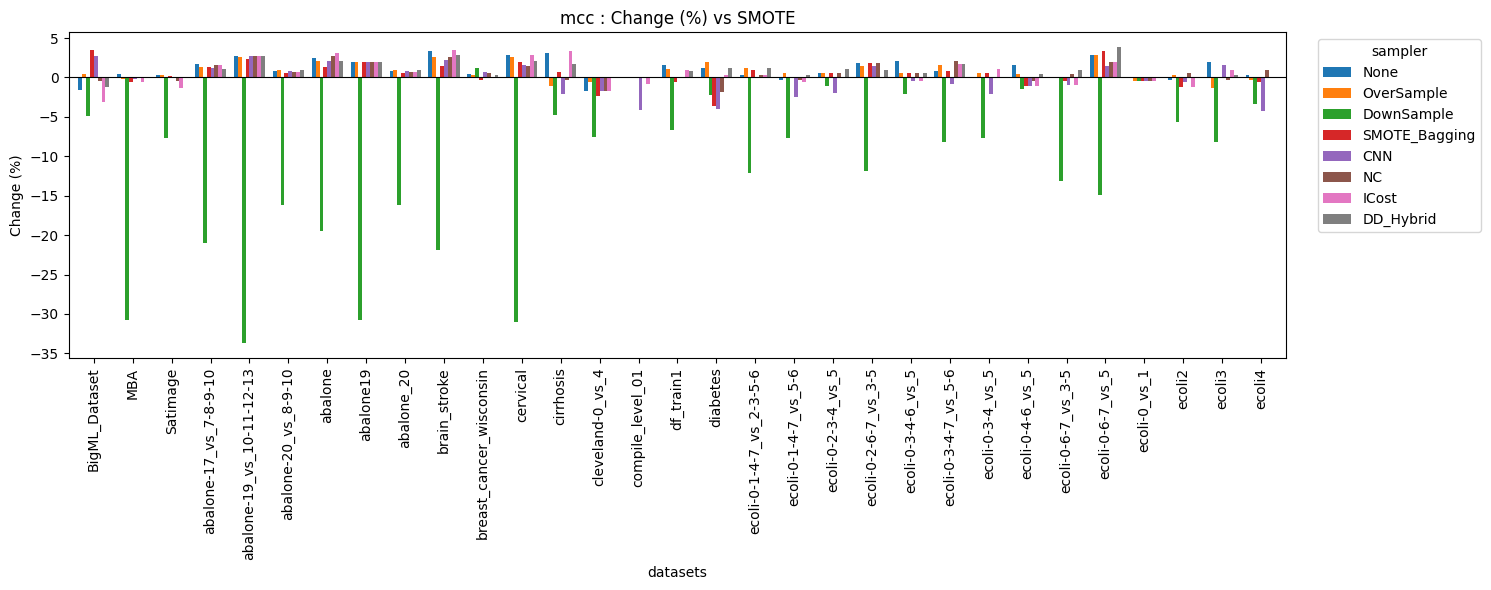

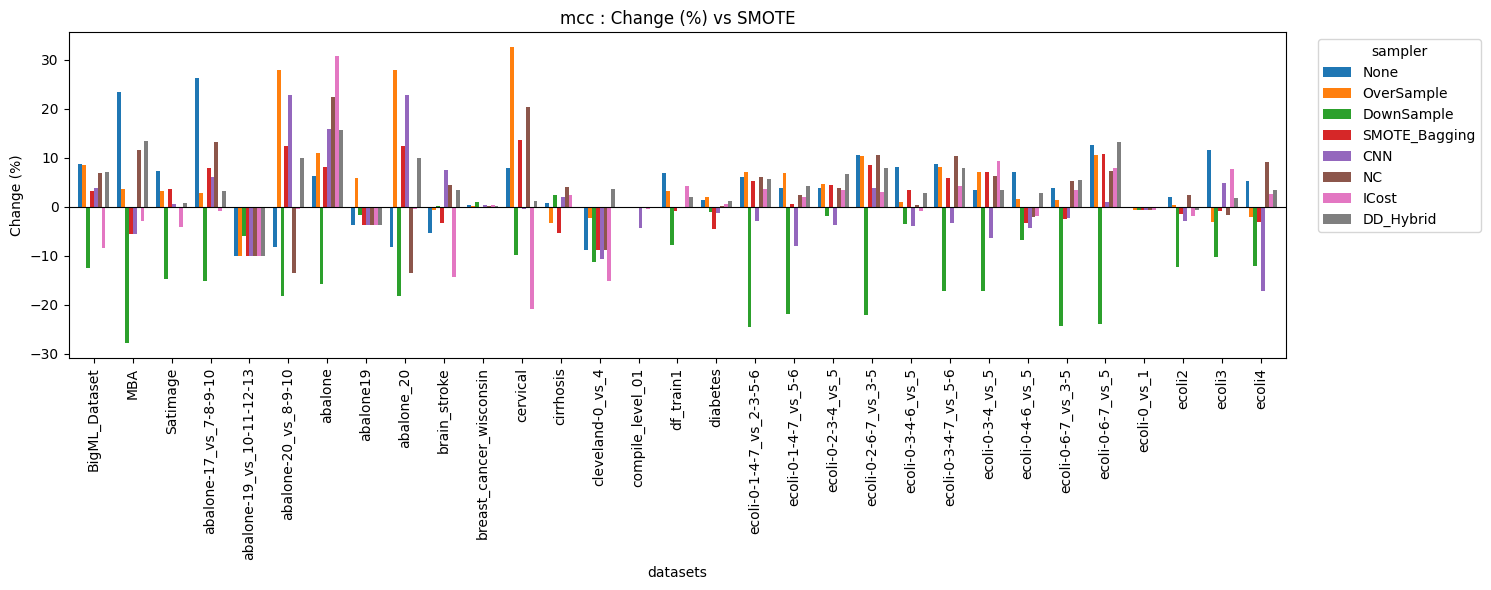

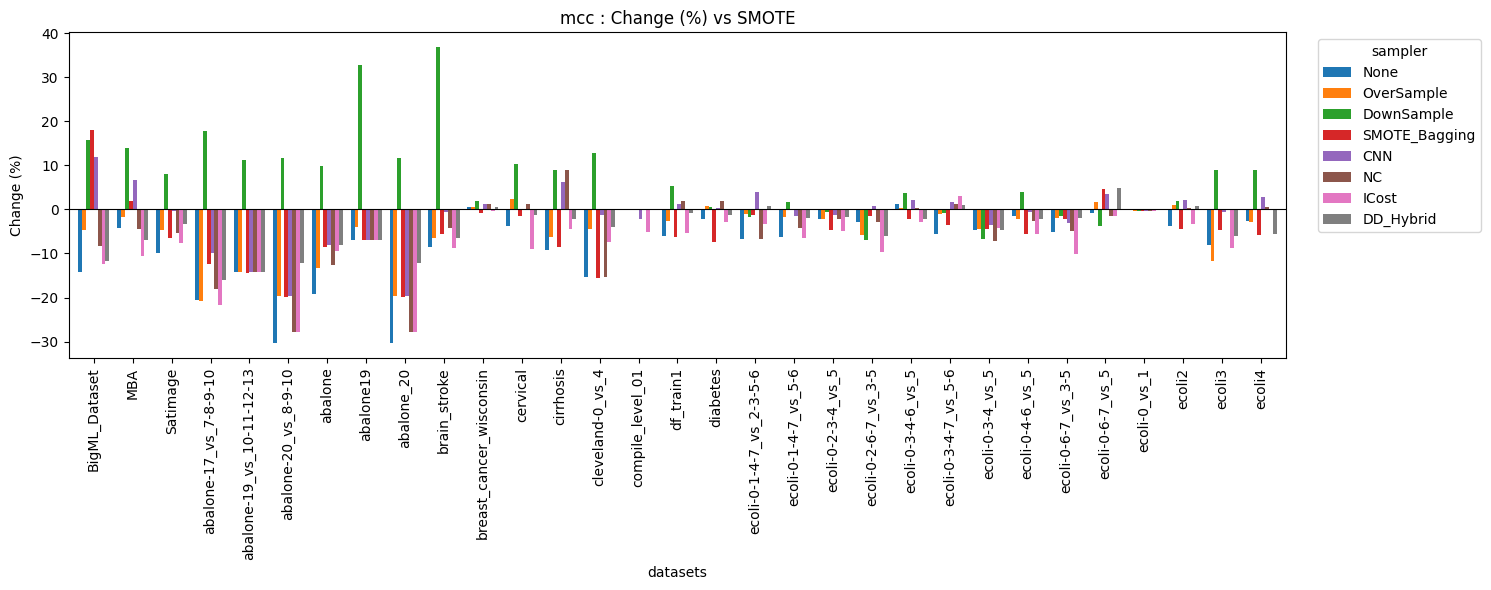

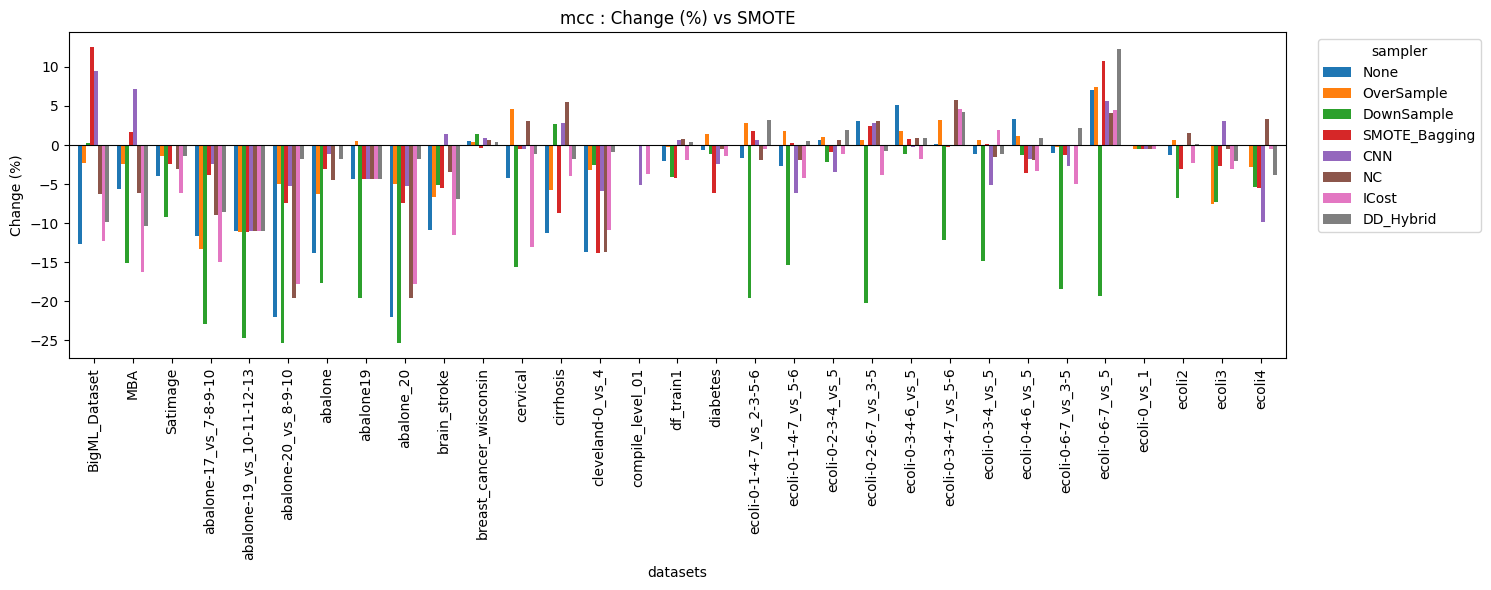

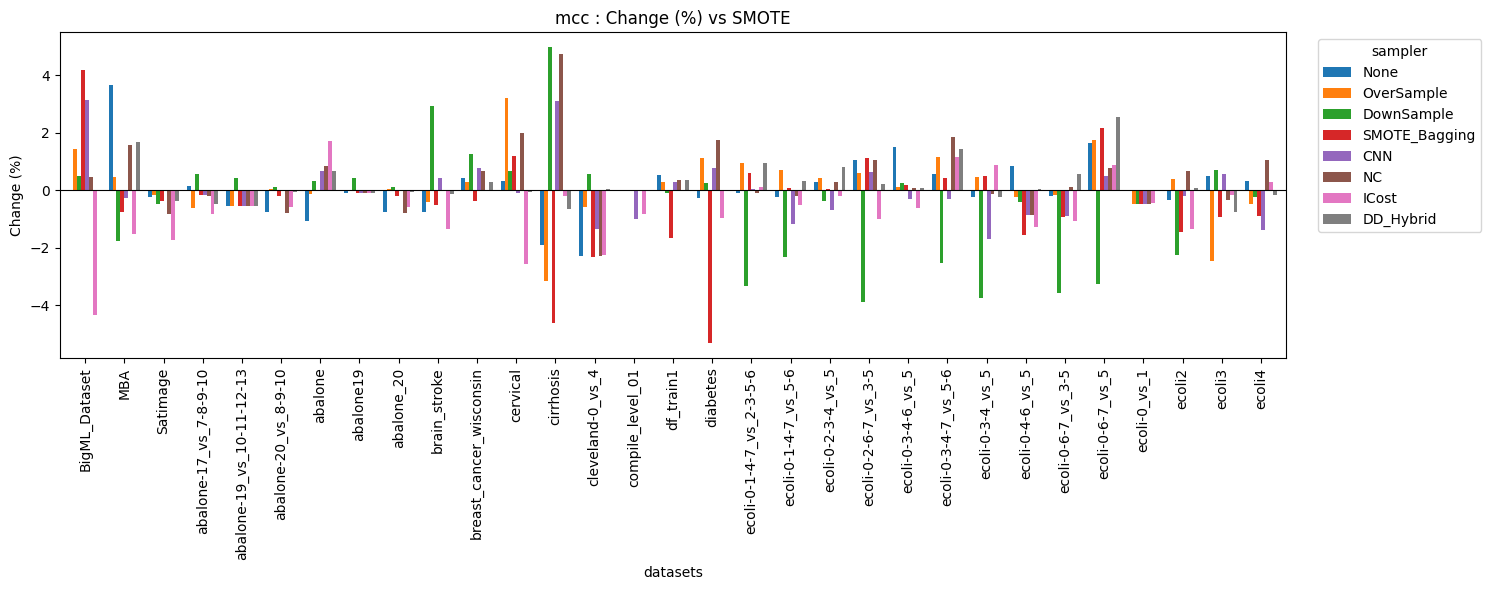

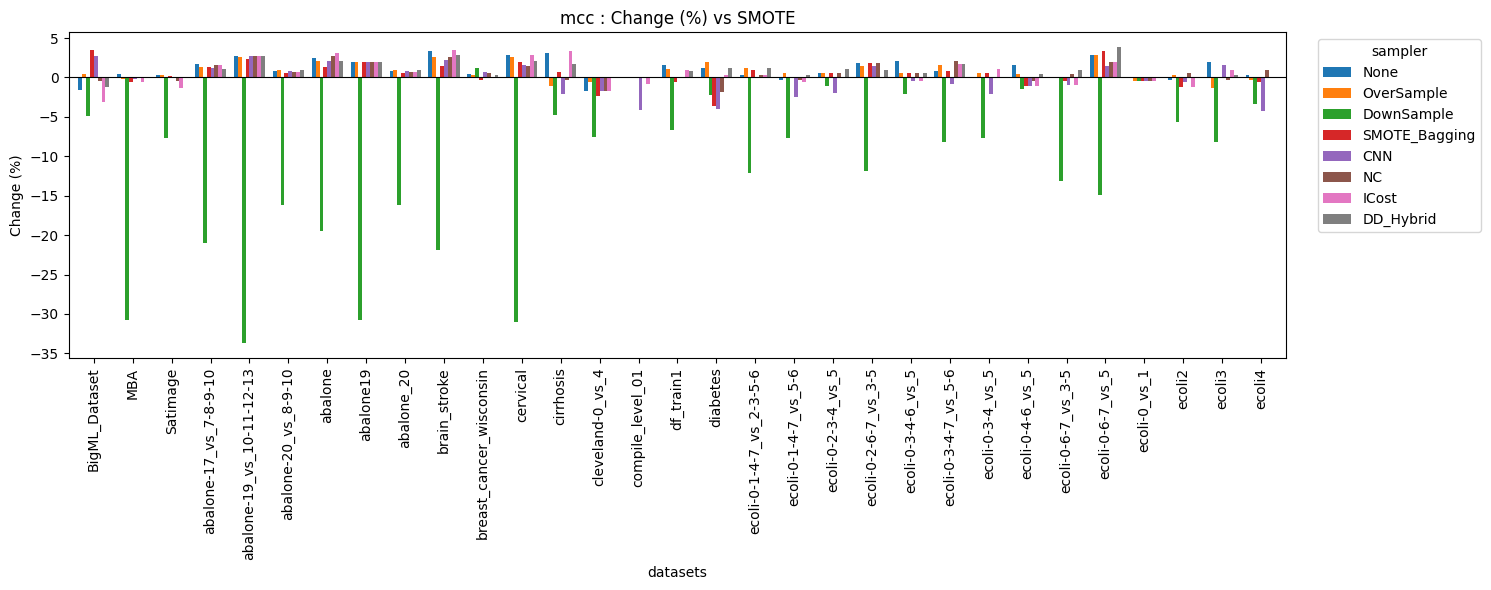

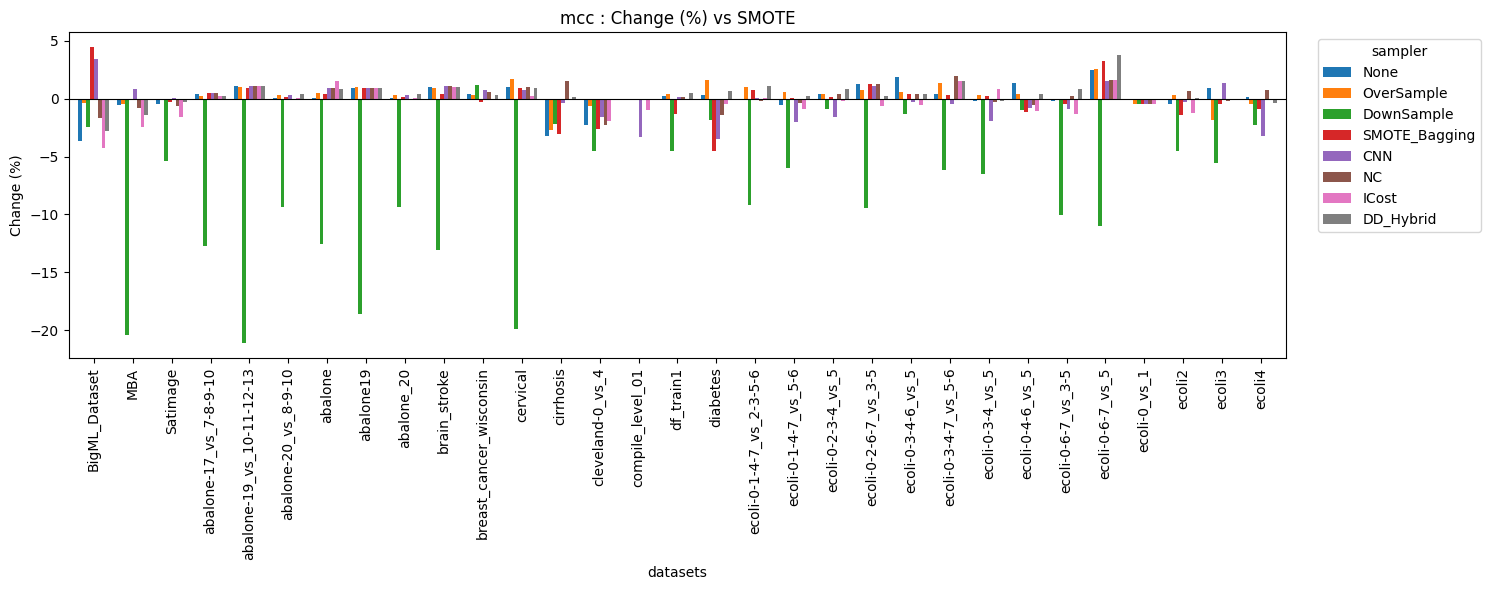

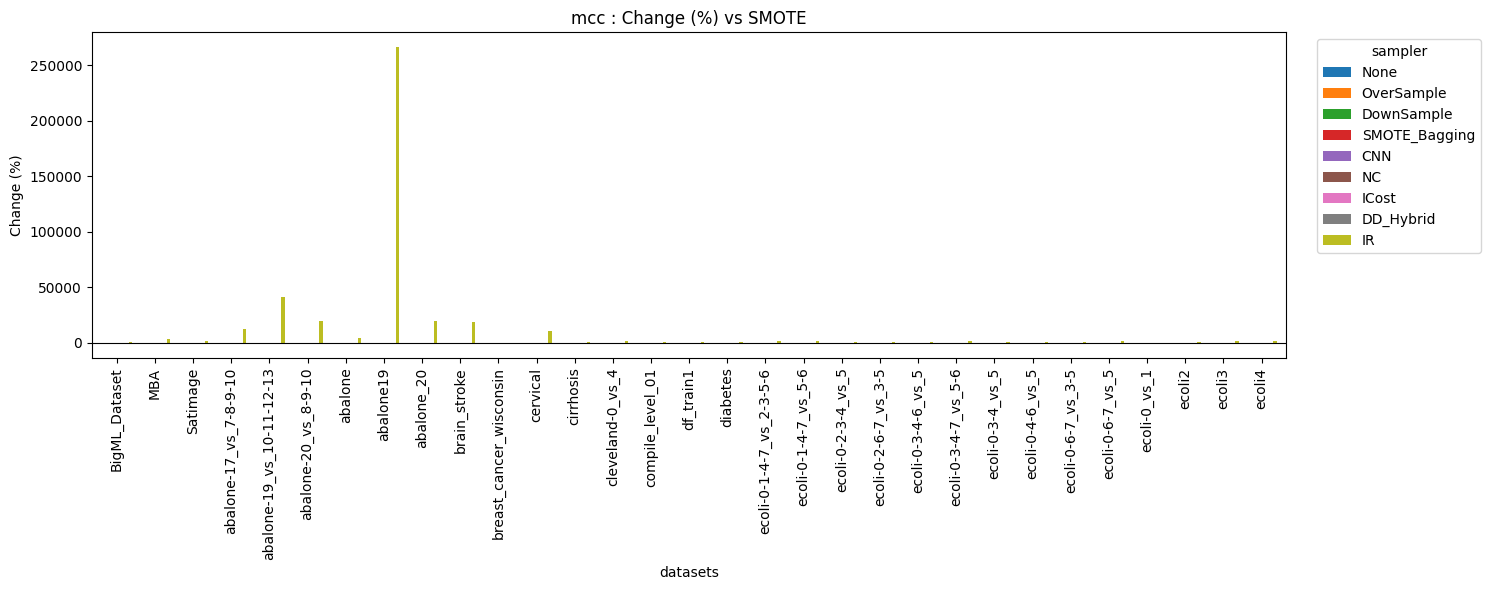

In [125]:
baseline = "SMOTE"

# for df in df_per_metric:
for name, df in df_per_metric.items():
        # metric = df.name
        df = df.dropna()
        rel = ((df.subtract(df[baseline], axis=0)
                .div(df[baseline], axis=0))*100).round(2)
        rel = rel.drop(columns=[baseline], errors="ignore")

        fig, ax = plt.subplots(figsize=(15, 6))
        rel.plot(kind="bar", ax=ax, width=0.8)
        ax.axhline(0, color="black", lw=0.8)
        ax.set_title(f"{metric} : Change (%) vs {baseline}")
        ax.set_ylabel("Change (%)")
        ax.set_xlabel("datasets")
        ax.legend(title="sampler", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        fig.savefig(OUT_DIR/f"rel_vs_{baseline}_{metric}.png", dpi=300)
        plt.show()
        plt.close(fig)

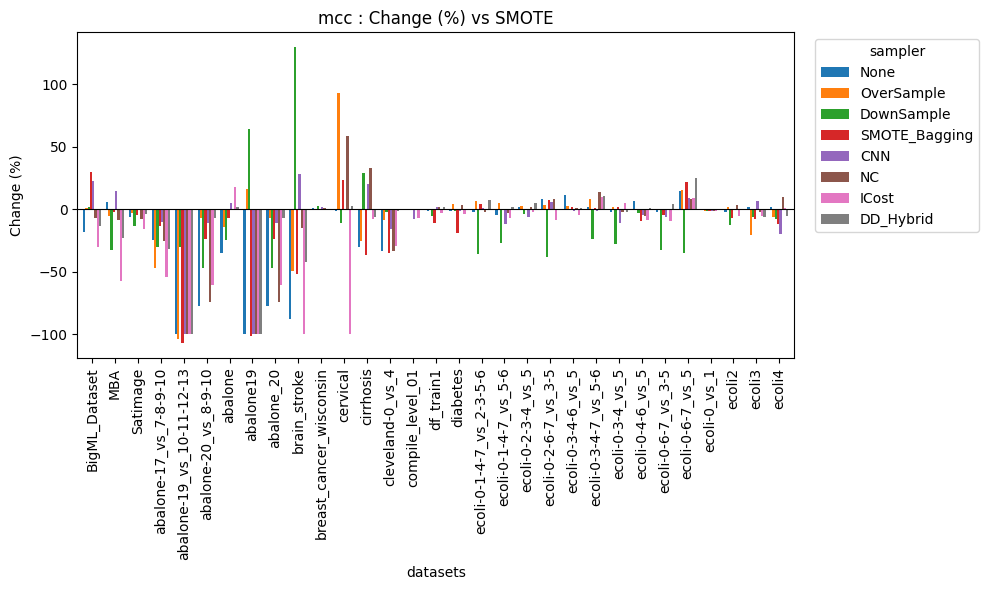

In [101]:
metric = "mcc"
df = df_per_metric[metric]
df = df.dropna()
df = df.drop(columns=["IR"])
rel = ((df.subtract(df[baseline], axis=0)
        .div(df[baseline], axis=0))*100).round(2)
rel = rel.drop(columns=[baseline], errors="ignore")

fig, ax = plt.subplots(figsize=(10, 6))
rel.plot(kind="bar", ax=ax, width=0.8)
ax.axhline(0, color="black", lw=0.8)
ax.set_title(f"{metric} : Change (%) vs {baseline}")
ax.set_ylabel("Change (%)")
ax.set_xlabel("datasets")
ax.legend(title="sampler", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
fig.savefig(OUT_DIR/f"rel_vs_{baseline}_{metric}.png", dpi=300)
plt.show()
plt.close(fig)

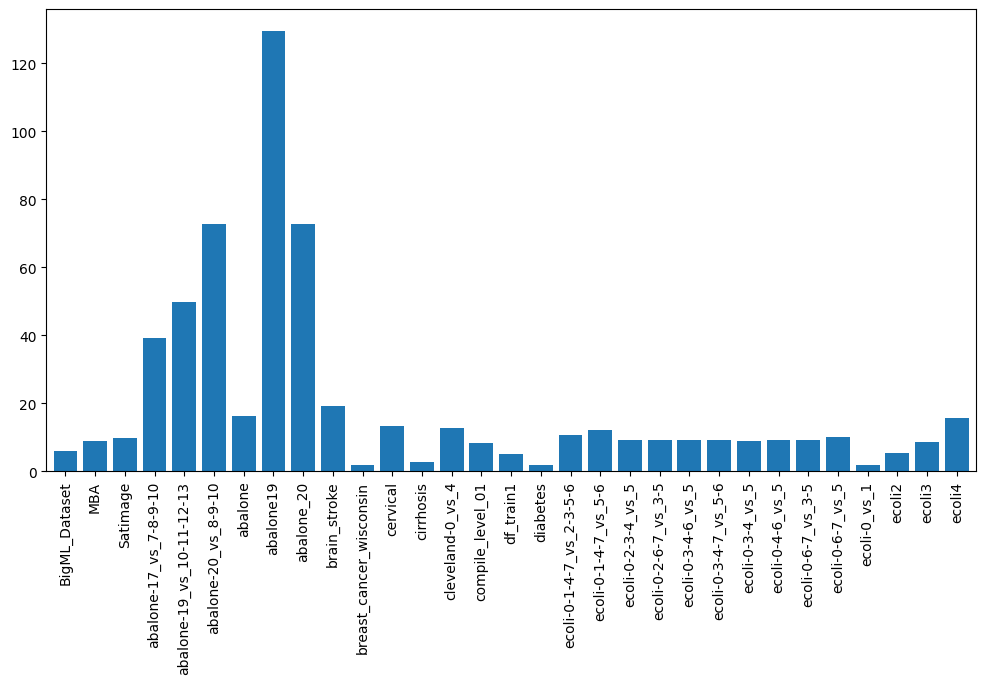

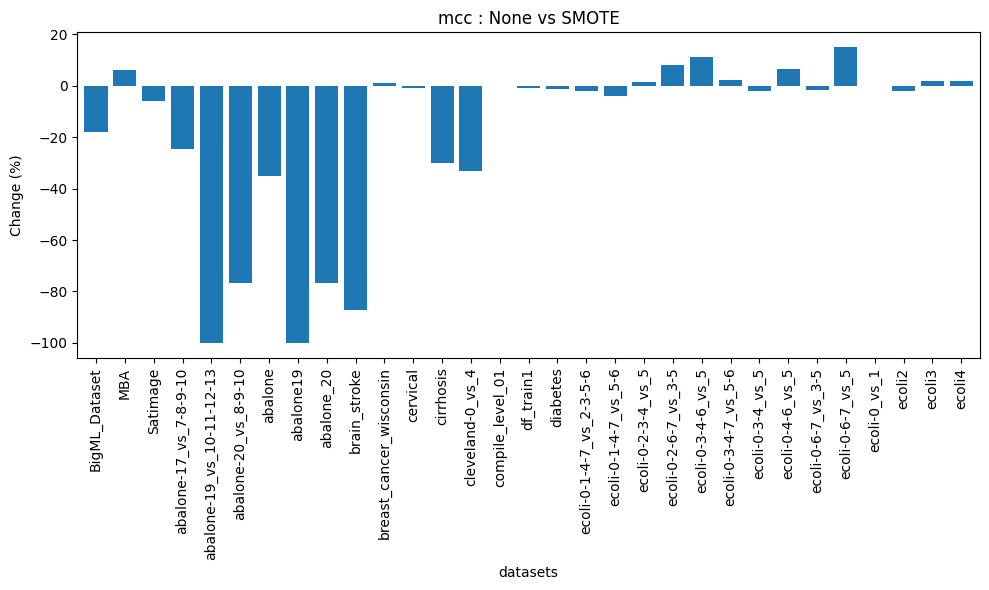

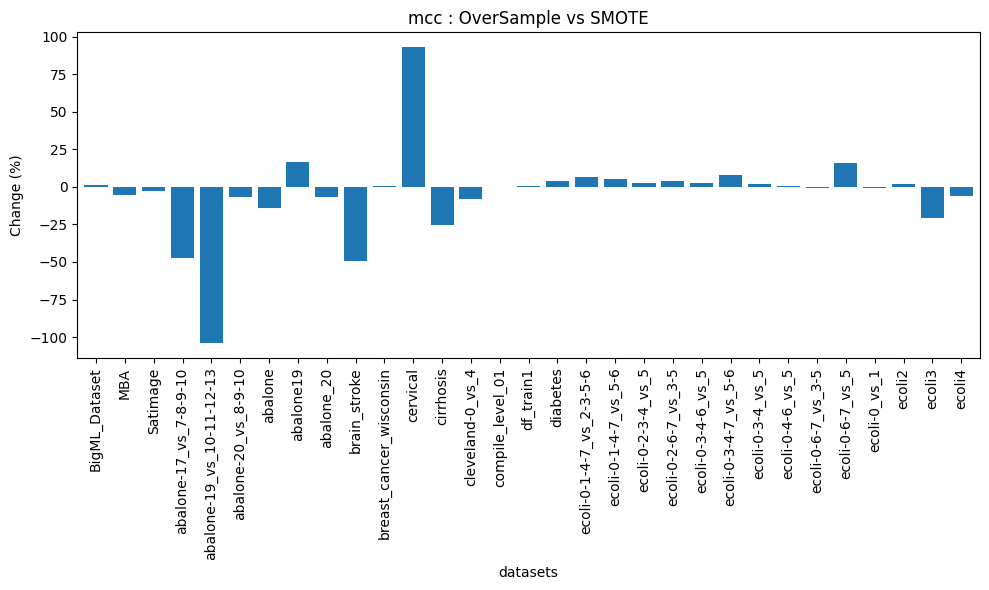

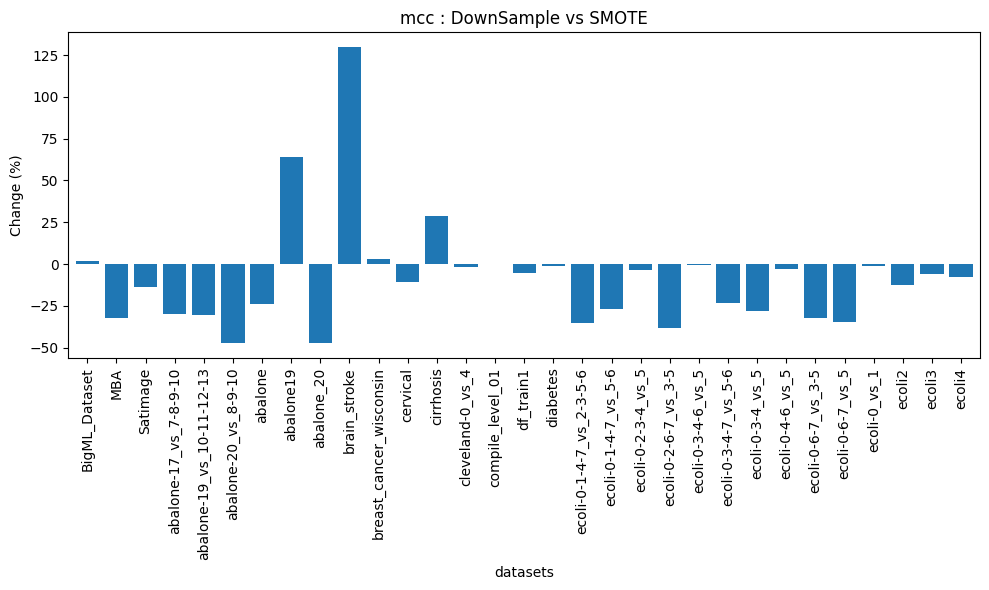

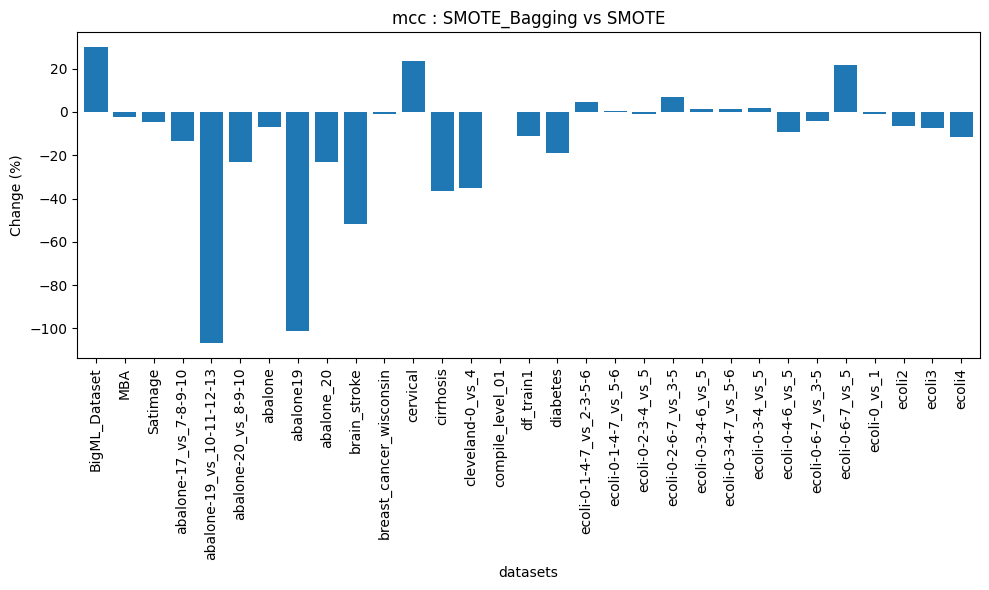

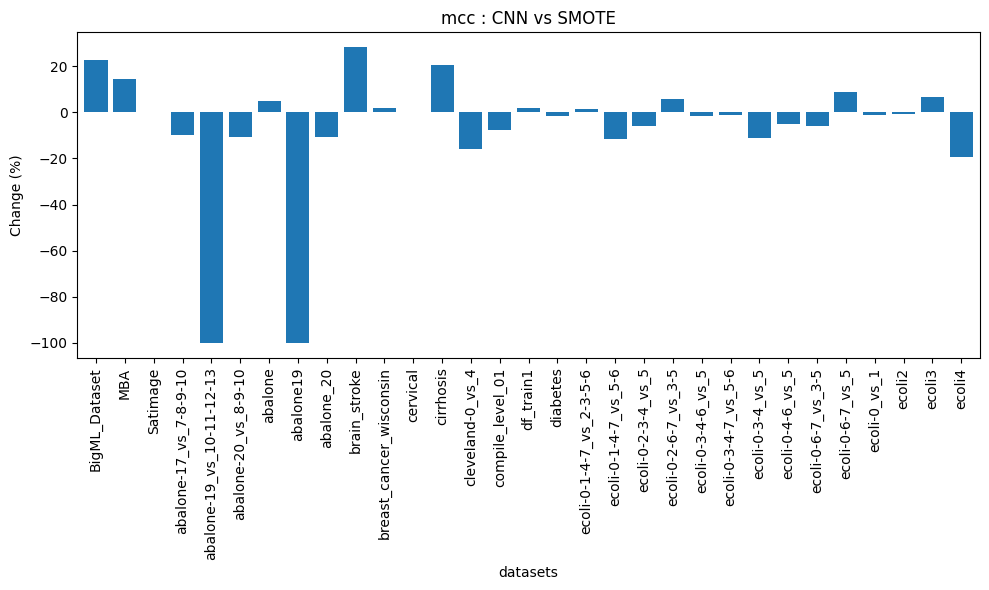

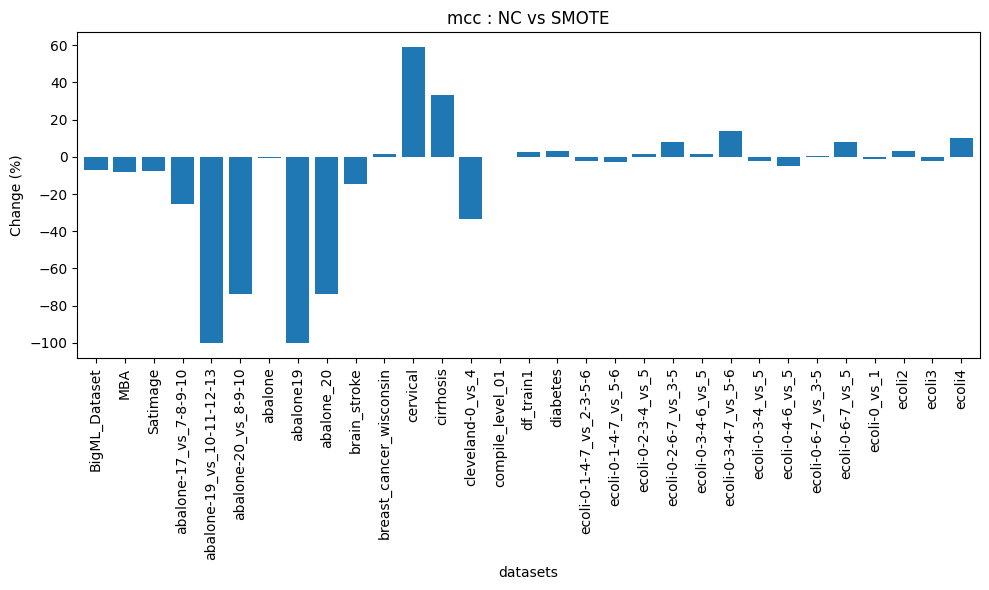

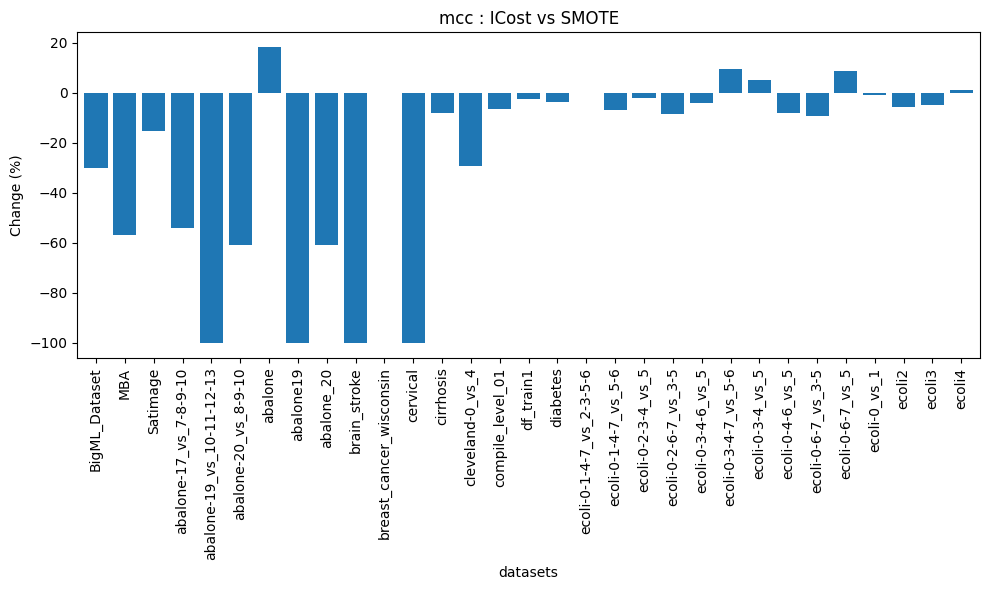

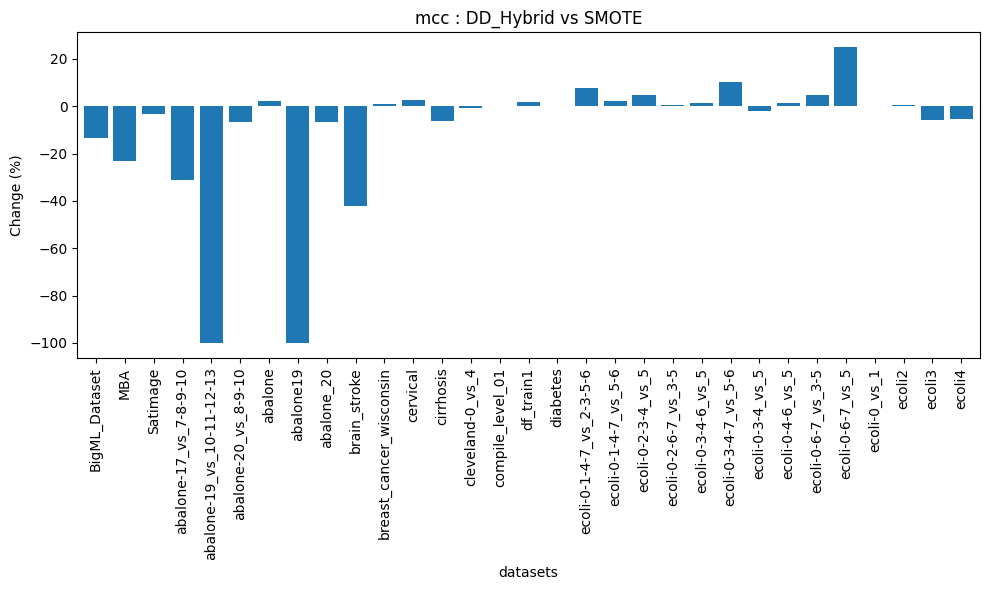

In [102]:
plt.figure(figsize=(12, 6))
pd.Series(scores["IR"])[rel.index].plot(kind="bar", width=0.8)

for sampler in rel.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    rel[sampler].plot(kind="bar", ax=ax, width=0.8)

    ax.set_title(f"{metric} : {sampler} vs {baseline}")
    ax.set_ylabel("Change (%)")
    ax.set_xlabel("datasets")
    plt.tight_layout()
    # fig.savefig(OUT_DIR/f"{sampler}_vs_{baseline}_{metric}.png", dpi=300)
    plt.show()
    plt.close(fig)



# 8.  Export CSVs

In [42]:
# for df in df_per_metric:
for name, df in df_per_metric.items():
    IR = pd.Series(scores["IR"] , name="IR")
    df = pd.concat([IR, df], axis=1)
    df.to_csv(OUT_DIR/f"{name}.csv")

✅ **Completed**